# Reductions
In class, we've seen that we can *reduce* one problem to another, by converting an instance of problem $A$ to an instance of problem $B$. We've seen that this allows us to prove that $B$ is at least as hard as $A$, but this also allows us to use an efficient black-box solver for problem $B$ to solve problem $A$. 

Namely, there exist many solver packages for Integer Linear Programming (CPLEX, Gurobi) and SAT (Glucose, Maplesat, Z3) which have been highly optimized over the course of several decades. Although these solvers take exponential time since ILP and SAT are NP-complete, good solver packages use advanced algorithms and are highly optimized, meaning they are very fast on reasonably-sized inputs. Rather than implement a solver from scratch, it may be more efficient to reduce a problem to integer LP or SAT in polynomial time and then call an existing solver library. 

It's common practice in operations research to frame problems such as airline scheduling or supply chain management as integer LPs and solve them using efficient commercial solvers.

> **Fun fact:** One popular commercial ILP solver, Gurobi, boasts that the NFL uses it to schedule football games!

In this notebook, we'll see how to solve the optimization variant of Set Cover by reducing it to integer LP and calling a black-box ILP solver. 

##### If you're using Datahub:
* Run the cell below **and restart the kernel if needed**

##### If you're running locally:
* Make sure you've activated the conda environment: `conda activate cs170`
* Launch jupyter: `jupyter notebook` or `jupyter lab` 
* Run the cell below **and restart the kernel if needed**

In [1]:
# Install dependencies
!pip install -r requirements.txt --quiet

In [2]:
import otter
assert (otter.__version__ >= "4.4.1"), "Please reinstall the requirements and restart your kernel."

grader = otter.Notebook("reductions.ipynb")
import itertools
import tqdm
import time
import random
import math
import pickle
import matplotlib.pyplot as plt
import pulp

from utils import *

rng_seed = 0

In [3]:
# load testing data
with open('data.pkl', 'rb') as f:
    U_test, S_test, ans_test = pickle.load(f)['testing']

## 1) Naive Set Cover
We've seen how to approximate Set Cover using a greedy algorithm, this approximation may not always be exact. What if we want an exact answer? Since Set Cover is NP-hard, we can't do much better than brute force unless P=NP. Below, implement a brute force solver for the Set Cover optimization problem. 

More formally, implement a brute force algorithm for the following:

Given a list of sets $S_1, S_2, \dots, S_m$ where each $S_i$ is a subset of the universe $U$, we want to pick the minimum number of sets from the collection such that their union contains all of $U$. Your answer should be a list of indices, where each index $i$ means that set $S_i$ is part of your set cover. Indices can be returned in any order. If no set cover is possible, return the empty list.

For simplicity, you can assume that all elements in $U$ are integers.

> **Note:** make sure you don't create a list of all possible subsets of U. Since there are $2^{|U|}$ such sets, this will take too much memory and kill the kernel. Instead, we recommend sticking the template code, which uses generators to avoid space usage issues.

In [17]:
def set_cover_naive(U, S):
    '''
    Brute-force impmenentation of the Set Cover optimization problem. 

    args:
        - U:List[int] is a list of all of the elements that we wish to cover.
        - S:List[Set[int]] is a list of sets; each set S[i] is a Python set of all of the items 
        that S[i] covers.
    returns:
        - List[int] depicting the minimal set cover of U. Each element in the 
            resulting list should be the index of a set in S. If there is no feasible cover, 
            return an empty list.
    '''
    all_indices = list(range(len(S)))
    U = set(U)

    # iterate over all values of k from 1 to |S|
    for k in range(1, len(S)+1):
        # iterate over all combinations of indices of length k
        for inds in itertools.combinations(all_indices, k):
            selected_sets = set()
            for ind in inds:
                selected_sets.update(S[ind])
            if U == selected_sets:
                return list(inds)
    return []


To help you debug, we've given you some sample test cases and answers to test your implementation.

Our tests are not comprehensive: we also encourage you to add your own test cases to test specific edge cases that might cause your code to fail.

In [18]:
for U, S, ans in tqdm.tqdm(zip(U_test, S_test, ans_test)):
    your_sol = set_cover_naive(U, S)

    if len(your_sol) > 0:
        assert ans > 0, 'Your solution says a feasible cover exists even though no such cover exists'

        your_cover = set([j for i in your_sol for j in S[i]])
        assert set(U).issubset(your_cover), 'Your solution does not cover all elements!'
    else:
        assert ans == 0, 'Your solution says no feasible cover exists even though a solution exists'

    assert len(your_sol) == ans, f'Optimal solution has length {ans} but yours has length {len(your_sol)}'

25it [00:01, 14.36it/s]


In [19]:
grader.check("q1")

100%|█████████████████████████████████████████| 117/117 [00:09<00:00, 12.51it/s]


q1 results: All test cases passed!

## 2) Black-box ILP Solver (not graded)

<b> For this part, you don't have to submit anything. If you're already comfortable with mathematical modeling and using PuLP, feel free to skip to Q3.</b>

By using a pre-made ILP solver library, much of the hard work is already done for us. We can assume that the solver gives correct results, and that the solver is pretty fast (as far as algorithms for NP-complete problems go).  

For this assignment, we'll use PuLP, which is a Python wrapper for various LP and integer LP solvers. In general, we'll treat the solver like a black box -- besides the Simplex algorithm we saw in class, you don't need to know any other LP solver algorithms or understand how PuLP works internally. In this question, we'll walk through the basics of formulating and solving integer LPs with PuLP.

As an example, let's say we want to solve the following integer LP:
$$\min_x \quad 3 x_0 + 4 x_1 + 6 x_2$$
<center> such that </center>

$$x_0 + 2 x_1 \ge 5$$
$$|x_1 - x_2| \le 2$$
$$x_0 + 2x_1 + 3x_2 \le 7$$
$$x_0, x_1, x_2 \in \mathbb{N}$$

First, we initialize a `pulp.LpProblem`. The constructor takes 2 arguments: 
1. The name of the problem (can be anything)
2. An optimization direction (either `pulp.LpMinimize` or `pulp.LpMaximize`). 

In [ ]:
problem = pulp.LpProblem('example_1', pulp.LpMinimize)

Next, we define our *optimization variables*. The variable constructor takes in a name parameter, followed by a few keyword arguments. For our purposes, we'll just look at the keyword arguments `lowBound`, which sets a lower bound on the variable, and `cat`, which describes the type of variable (can be either `'Continuous'`, `'Integer'`, or `'Binary'`. Note that using integer or binary variables will make our problem take much longer to solve). 

Not only does PuLP support defining single variables, but PuLP also supports defining multiple variables at once with the `dicts` method. This takes in an additional parameter `indices`, and returns a dictionary with elements of `indices` as keys and the PuLP variables as the values. `indices` could be any iterable, but here we'll use `range(3)` to make indexing easy. 

We'll also define an additional slack variable to deal with the absolute value constraint in our problem.

In [ ]:
# Optimization variables
x = pulp.LpVariable.dicts(name='x', indices=range(3), lowBound=0, cat='Integer') 
# Slack variable
t = pulp.LpVariable(name='t', lowBound=0, cat='Integer')

After defining our variables, we must set the *objective function*. This should be an affine function, i.e. involving only a linear combination of the optimization variables plus some constant. To make indexing easier, we can also define a coefficient array and use a list comprehension (or generator expression). 

Recall that `x` was assigned using the `dicts` constructor, which returns a dictionary where each key-value pair is of the form `(variable_name, variable_object)`. When defining the objective function, we want to work with the variables themselves but don't care about the names, so we'll iterate over just the values of the dictionary.

In [ ]:
coeffs = [3, 4, 6]

# objectives can be hard-coded or set using a list comprehension
problem.setObjective(sum([c_i * x_i for c_i, x_i in zip(coeffs, x.values())]))

# this statement is equally valid and functionally equivalent - the square brackets are optional in a sum expression
problem.setObjective(sum(c_i * x_i for c_i, x_i in zip(coeffs, x.values())))

Finally, we'll define our *constraints*. PuLP supports `<=`, `>=`, and `==` constraints. Notice how we handled the absolute value constraint by using a slack variable. Also note that the nonnegativity constraints were taken care of using `lowBound` when we defined our variables, so we don't need to repeat them here.

In [ ]:
problem.addConstraint(x[0] + 2*x[1] >= 5)

# handle the absolute value constraint using slack variables
problem.addConstraint(t >= x[1] - x[2])
problem.addConstraint(t >= -1*(x[1] - x[2]))
problem.addConstraint(t <= 2)

Just like when we set the objective function, if we are given a list of coefficients, we can quickly generate constraints using Python list comprehensions. Here, we use the `zip` function to iterate over the coefficients and the variables simultaneously.

If you want a refresher on `zip` or list comprehensions, consider checking out the following:

https://cs61a.org/study-guide/iterators/#generators 

https://cs61a.org/lab/lab04/#list-comprehensions

In [ ]:
a = [1, 2, 3]

# just like before, the following two lines are equivalent and are both valid. 
problem.addConstraint(sum([a_i * x_i for a_i, x_i in zip(a, x.values())]) <= 7)

# again, the square brackets are optional here
problem.addConstraint(sum(a_i * x_i for a_i, x_i in zip(a, x.values())) <= 7)

We can print the problem to make sure our objective and constraints make sense:

In [ ]:
print(problem)

To actually solve or LP, we just call `problem.solve()`. 

Here, we pass `pulp.PULP_CBC_CMD(msg=0)` into `problem.solve()` to suppress console outputs and avoid cluttering the notebook. This is totally optional and can be removed if you like.

After optimizing, we should first check whether the solver found an optimal solution by checking `problem.status`. If `problem.status` is 1, then the solver found an optimal solution. Otherwise, the status will be different if the problem is infeasible, unbounded or if the solver otherwise fails. See the [documentation](https://www.coin-or.org/PuLP/constants.html#pulp.constants.LpStatus) for the full list of status values. 

If an optimal solution is found, we can get the optimum objective value from `problem.objective.value()` as shown below. The optimum variable values are stored in their respective variable objects.

> **Note:** If the solver fails to find an optimal solution (for instance if the problem is infeasible), the solver will not throw an error. Instead, the solver will set `problem.status` to something other than 1 and the objective value and objective variables will be garbage. So make sure to check that `problem.status` is 1 before checking the objective value or accessing the decision variables.

In [ ]:
problem.solve(pulp.PULP_CBC_CMD(msg=0))
if problem.status == 1:
    print(f'Optimal objective value: {problem.objective.value()}')
else:
    print("The solver couldn't find an optimal solution.")

> **Exercise (optional)**: Try adding a new constraint which will make the LP infeasible, and see what happens when you try to solve it by rerunning the cell above.

In [ ]:
# add additional constraints here
...

After solving, the we can use this code to extract the optimum variable values. `problem.variablesDict()` returns a dictionary of all variables which are used in our LP, and for each variable `v`, we can access `v.name` to see the variable's name or call `v.value()` to see its value.

In [ ]:
[(v.name, v.value()) for v in problem.variablesDict().values()]

we can also use `problem.variables()` to get a list of all variables, and iterate over them to get their names and values.
> **Note:** Beware that this may not return variables in the order that you expect! (try changing $x$ to have dimension larger than 10 and see what happens)

In [ ]:
[(v.name, v.value()) for v in problem.variables()]

If you have any further questions about PuLP or if you want to see more examples, feel free to consult the [documentation](https://coin-or.github.io/pulp/).

## 3) Using the Solver
Now it's your turn! Use PuLP to solve the following LP:
$$\max_x \quad \sum_{i=1}^5 2^{5-i} x_i$$
<center> such that </center>

$$2 \sum_{j=1}^{i} 2^{i-j} x_j \le 100^{i-1} \quad \forall \, 1 \le i \le 5$$
$$x_i \ge 0 \quad \forall i$$

Then, store your answer for the optimal objective value in the variable `sol`.

> **Fun fact:** This particular LP is known as the Klee-Minty problem, and is an example of a problem where Dantzig's Simplex algorithm requires an exponential number of iterations.

In [20]:
problem = pulp.LpProblem('q3', pulp.LpMaximize)

# add variables, objective, and constraints here

x = pulp.LpVariable.dicts(name='x', indices=range(5), lowBound=0)

obj = sum(2 ** (5 - i) * x[i - 1] for i in range(1, 6))

problem.setObjective(obj)

for i in range(1, 6):
    cons = (sum(2 ** (i - j) * x[j - 1] for j in range(1, i + 1))) * 2 <= 100 ** (i - 1)
    problem.addConstraint(cons)

problem.solve()

sol = problem.objective.value()


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/plus1/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/97/dkw6z2ts52q6bdx9939nslvm0000gn/T/fbd062788c224328a74eab4653137829-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/97/dkw6z2ts52q6bdx9939nslvm0000gn/T/fbd062788c224328a74eab4653137829-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10 COLUMNS
At line 31 RHS
At line 37 BOUNDS
At line 38 ENDATA
Problem MODEL has 5 rows, 5 columns and 15 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (-1) rows, 5 (0) columns and 14 (-1) elements
0  Obj 48979592 Primal inf 63775.507 (1) Dual inf 79.999995 (5)
5  Obj 50000000
Optimal - objective value 50000000
After Postsolve, objective 50000000, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 50000000 - 5 iterations time 0.002, Presolve 0.0

In [21]:
grader.check("q3")

q3 results: All test cases passed!

## 4) Reducing Set Cover to ILP
Now that we know how to formulate and solve ILPs, let's complete the reduction. We'll walk through this reduction step-by-step, where we will:
1. Construct an instance of ILP based on the problem instance given
2. Solve the ILP we just created using PuLP
3. Use the solution to the ILP to construct the optimal solution to the Set Cover problem

You will create the ILP problem in the function `create_lp` below. For this part, please use at most $m+n$ variables (including any slack variables), and at most $m+n$ constraints, where $n=|U|$ is the number of elements we wish to cover, and $m$ is the number of sets that we have. 

In `reconstruct_set_cover`, you will use the solution to the ILP you just generated to construct the optimal solution to the Set Cover problem. 

Finally, `set_cover_reduction` will tie together everything you've just implemented and return the optimal solution to the Set Cover problem.

> **Note:** For this problem, you are required to implement both helper functions. Do not modify the function signatures in any way. 

In [44]:
def create_lp(U, S):
    '''
    Creates a pulp.LpProblem object for the Set Cover optimization problem. 

        args:
        - U:List[int] is a list of all of the elements that we wish to cover.
        - S:List[Set[int]] is a list of sets; each set S[i] is a Python set of all of the items 
        that S[i] covers.
    returns:
        - pulp.LpProblem object for the Set Cover optimization problem.
    '''
    problem = pulp.LpProblem('Set_Cover', pulp.LpMinimize)

    # set appropriate variables
    x = pulp.LpVariable.dicts('x', indices=range(len(S)), lowBound=0, upBound=1, cat=pulp.LpBinary)


    # set an appropriate objective function
    obj = sum(x[i] for i in range(len(S)))
    problem.setObjective(obj)

    # set appropriate constraints
    for c in U:
        cons = pulp.lpSum([x[i] for i in range(len(S)) if c in S[i]]) >= 1
        problem.addConstraint(cons)
    # print(U)
    return problem

def reconstruct_set_cover(U, S, problem):
    '''
    Reconstructs the set cover from the solution to the ILP. 
    Assume we already called problem.solve(), so you have access to 
    proble.status, problem.objective.value(), and the values of any decision variables.

    args:
        - U:List[int] is a list of all of the elements that we wish to cover.
        - S:List[Set[int]] is a list of sets; each set S[i] is a Python set of all of the items 
        that S[i] covers.
        - problem:pulp.LpProblem is a pulp.LpProblem object for the Set Cover optimization problem.
    returns:
        - List[int] depicting the minimal set cover of U. Each element in the 
            resulting list should be the index of a set in S. If there is no feasible cover, 
            return an empty list.
    '''

    if problem.status != 1:
        return []
    selected = []
    for x in problem.variables():
        if x.value() == 1:
            selected.append(int(x.name[2:]))
    # print(selected)
    return selected


def set_cover_reduction(U, S):
    '''
    Impmenentation of the Set Cover optimization problem using reduction to ILP. 
    You should use the two helper functions you implemented above.

    args:
        - U:List[int] is a list of all of the elements that we wish to cover.
        - S:List[Set[int]] is a list of sets; each set S[i] is a Python set of all of the items 
        that S[i] covers.
    returns:
        - List[int] depicting the minimal set cover of U. Each element in the 
            resulting list should be the index of a set in S. If there is no feasible cover, 
            return an empty list.
    '''
    
    # Generate the LP formulation using the helper function you just made
    problem = create_lp(U, S)

    # Solve the LP. You can remove pulp.PULP_CBC_CMD(msg=0) if you want to see problem info.
    problem.solve(pulp.PULP_CBC_CMD(msg=0))

    # reconstruct the set cover solution based on the ILP solution. Again, use the helpers you just made.
    sol = reconstruct_set_cover(U, S, problem)
    return sol

Again, we've provided you with some basic validation code. 

Our tests are not comprehensive: we also encourage you to add your own test cases to test specific edge cases that might cause your code to fail.

In [45]:
for U, S, ans in tqdm.tqdm(zip(U_test, S_test, ans_test)):
    your_sol = set_cover_reduction(U, S)

    if len(your_sol) > 0:
        assert ans > 0, 'Your solution says a feasible cover exists even though no such cover exists'

        your_cover = set([j for i in your_sol for j in S[i]])
        assert set(U).issubset(your_cover), 'Your solution does not cover all elements!'
    else:
        assert ans == 0, 'Your solution says no feasible cover exists even though a solution exists'

    assert len(your_sol) == ans, f'Optimal solution has length {ans} but yours has length {len(your_sol)}'

25it [00:01, 22.19it/s]


In [46]:
grader.check("q4")

100%|█████████████████████████████████████████| 165/165 [00:10<00:00, 15.44it/s]


q4 results: All test cases passed!

### Compare runtime of the ILP reduction vs. Brute-force solver
After running the q4 tests and looking at the generated graph, hopefully you will see that the naive solver is faster than the ILP reduction for small examples but the ILP reduction is faster for large examples. This highlights some of the tradeoffs between the two approaches: the ILP solver is more optimized for larger examples, but calling the solver incurs additional overhead, making it slower for small cases. On the flip side, the naive solver introduces relatively little additional overhead, but performs poorly on larger problems.

For this part, just run the cell and look at the output. You don't have to implement anything, and you don't have to hit any particular efficiency target. 

165it [00:41,  3.96it/s]


Approximate speedup: 2.973


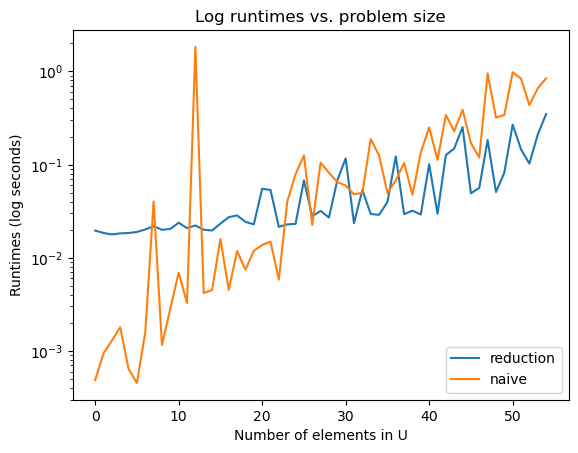

In [47]:
timing_helper(set_cover_reduction, set_cover_naive)

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit.

In [48]:
grader.export(pdf=False, force_save=True, run_tests=True)

<IPython.core.display.Javascript object>

/Users/plus1/anaconda3/lib/python3.11/site-packages/otter/check/notebook.py:355: UserWarning: Couldn't automatically save the notebook; we recommend using File > Save & Checkpoint and then re-running this cell. The zip file returned by this call will use the last saved version of this notebook.
  warnings.warn(


Running your submission against local test cases...

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/plus1/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/97/dkw6z2ts52q6bdx9939nslvm0000gn/T/e06630b6b08241778573d38aa79253a8-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/97/dkw6z2ts52q6bdx9939nslvm0000gn/T/e06630b6b08241778573d38aa79253a8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 10 COLUMNS
At line 31 RHS
At line 37 BOUNDS
At line 38 ENDATA
Problem MODEL has 5 rows, 5 columns and 15 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (-1) rows, 5 (0) columns and 14 (-1) elements
0  Obj 48979592 Primal inf 63775.507 (1) Dual inf 79.999995 (5)
5  Obj 50000000
Optimal - objective value 50000000
After Postsolve, objective 50000000, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objec